# Task 1
the number of training images is 5,000

## Step 1: Import relevant packages
We will mainly be using SciKit-Learn for this lab, so make sure you have correctly installed this
library before moving to the next steps. Check the following link to learn more about the library and ways to install it

In [30]:
import os
import re
import random
import shutil
import cv2
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Download the dataset
Download the dataset from WebCMS3 or from the original Kaggle webpage (linked above)
and familiarize yourself with it. Specifically, you can check how many images and labels there
are in the entire dataset, what the size of each image is, how many classes there are and how
many images are in each class. Also, have a look at some images of each label.

## Step 3: Split and sample the dataset
There are 15,000 images in the dataset. To reduce computational cost, we can work with a
subset of the complete dataset. Initially, take 5,000 randomly sampled images for training and
1,000 randomly sampled images for testing.
Make sure that random sampling is done in a stratified way. That is, it must be done such that
the number of images in each class ends up being approximately the same. With 15 classes,
you should have about 333 images of each class in the training set, and about 66 images of
each class in the testing set. This is to avoid class imbalance in training and testing.
Also make sure that the test images are not included in the training set. The training and
testing sets must be completely separate. This is to avoid leakage from the training to the
testing results (it is generally easier for a classifier to correctly classify a sample from the
training set than a new sample it has never seen before)

In [43]:
dataDir = './data'
outputDir = './dataset_split'
trainSize = 5000
testSize = 1000
TOTAL_CLASSES = 15
random.seed(42)

# collect label
pattern = re.compile(r"input_(\d+)_(\d+)_(\d+)\.jpg")
image_paths = []
labels = []

for root, _, files in os.walk(dataDir):
    for file in files:
        if file.endswith('.jpg'):
            match = pattern.match(file)
            if match:
                _, _, char_id = map(int, match.groups())
                image_paths.append(os.path.join(root, file))
                labels.append(char_id)

print(f"find {len(image_paths)} images")

# Make sure that random sampling is done in a stratified way
splitter = StratifiedShuffleSplit(
    n_splits=1,
    train_size=trainSize,
    test_size=testSize,
    random_state=42
)

image_paths = np.array(image_paths)
labels = np.array(labels)

for train_idx, test_idx in splitter.split(image_paths, labels):
    train_files = image_paths[train_idx]
    test_files = image_paths[test_idx]
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]

print(f"training set: {len(train_files)} , testing set: {len(test_files)} ")

# create dataset_spilt
def copy_files(files, labels, split_name):
    for path, label in zip(files, labels):
        label_dir = os.path.join(outputDir, split_name, f"class_{label}")
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy2(path, os.path.join(label_dir, os.path.basename(path)))

copy_files(train_files, train_labels, 'train')
copy_files(test_files, test_labels, 'test')

print("training set distributin：", Counter(train_labels))
print("testing set distributin：", Counter(test_labels))

find 15000 images
training set: 5000 , testing set: 1000 
training set distributin： Counter({np.int64(12): 334, np.int64(6): 334, np.int64(1): 334, np.int64(14): 334, np.int64(10): 334, np.int64(5): 333, np.int64(9): 333, np.int64(13): 333, np.int64(3): 333, np.int64(7): 333, np.int64(8): 333, np.int64(11): 333, np.int64(15): 333, np.int64(4): 333, np.int64(2): 333})
testing set distributin： Counter({np.int64(2): 67, np.int64(4): 67, np.int64(13): 67, np.int64(9): 67, np.int64(15): 67, np.int64(8): 67, np.int64(5): 67, np.int64(11): 67, np.int64(3): 67, np.int64(7): 67, np.int64(1): 66, np.int64(6): 66, np.int64(10): 66, np.int64(12): 66, np.int64(14): 66})


# Step 4: Perform necessary data reshaping
Once you get a subset of the dataset to work with, you need to reshape the training and testing
data in order to apply machine learning classifiers. Each image in the Chinese MNIST dataset
is 64 x 64 pixels, so you need to reshape it.

In [33]:
datasetDir = './dataset_split'
imgSize = (64, 64)
colorMode = 'grayscale'

# load dataset
def load_dataset(split):
    data = []
    labels = []
    split_dir = os.path.join(datasetDir, split)
    
    for class_name in sorted(os.listdir(split_dir)):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                img_path = os.path.join(class_dir, filename)
                
                if colorMode == 'grayscale':
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                else:
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, imgSize)
                
                data.append(img)
                labels.append(class_name)
    
    return np.array(data), np.array(labels)

# load train & test
X_train, y_train = load_dataset('train')
X_test, y_test = load_dataset('test')

print("origin：", X_train.shape, y_train.shape)

# reshape
if colorMode == 'grayscale':
    n_features = imgSize[0] * imgSize[1]
    X_train = X_train.reshape(len(X_train), n_features)
    X_test = X_test.reshape(len(X_test), n_features)
else:
    n_features = imgSize[0] * imgSize[1] * 3
    X_train = X_train.reshape(len(X_train), n_features)
    X_test = X_test.reshape(len(X_test), n_features)

# label encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print("train dataset reshape:", X_train.shape, y_train.shape)
print("test dataset reshape:", X_test.shape, y_test.shape)
print("classes:", len(le.classes_))

origin： (5000, 64, 64) (5000,)
train dataset reshape: (5000, 4096) (5000,)
test dataset reshape: (1000, 4096) (1000,)
classes: 15


# Step 5: Initialise the classifier
For each classifier (KNN, DT, SGD), initialise the classifier object. It is important to read the
documentation to learn about various parameters that can be configured when initialising
classifiers. For KNN, set k to 3. For SGD, set the maximum number of iterations (epochs) to 250. Use default settings for all other parameters.

In [ ]:
# KNN, k=3
knn_clf = KNeighborsClassifier(n_neighbors=3)

# decision tree, default
dt_clf = DecisionTreeClassifier()

# SGD, maximum iterations = 250
sgd_clf = SGDClassifier(max_iter=250)

print(" Classifiers initialised")

 Classifiers initialised


# Step 6: Fit the classifier to the training data
The SciKit-Learn library has a fitting method to learn from data. Use the fit() method to
train each classifier by passing the training data and the training labels as parameters. The
correct label (class) of each image follows from the file name (or the separate CSV file).

In [ ]:
# train KNN
knn_clf.fit(X_train, y_train)

# train decision tree
dt_clf.fit(X_train, y_train)

# train SGD
sgd_clf.fit(X_train, y_train)

print("training done")

training done


# Step 7: Evaluate the trained model on the testing data
After you have trained a classifier (also called a model), you can use it to make predictions on
the testing data. Use the predict() method provided by the SciKit-Learn library

In [ ]:
# KNN
y_pred_knn = knn_clf.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

# decision tree
y_pred_dt = dt_clf.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

# SGD
y_pred_sgd = sgd_clf.predict(X_test)
acc_sgd = accuracy_score(y_test, y_pred_sgd)

print("make predictions on the testing data:")
print(f"KNN accuracy: {acc_knn}")
print(f"Decision Tree accuracy: {acc_dt}")
print(f"SGD accuracy: {acc_sgd}")

make predictions on the testing data:
KNN accuracy: 0.36
Decision Tree accuracy: 0.246
SGD accuracy: 0.307


# Step 8: Report the performance of each classifier
To quantify how each of the trained classifiers performs, use standard classification metrics
such as accuracy, precision, recall, and the F1-score. To summarise the errors for each class,
use the confusion matrix.


# KNN 

Accuracy: 0.36

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.47      0.60        66
           1       0.52      0.38      0.44        66
           2       0.30      0.60      0.40        67
           3       0.50      0.20      0.28        66
           4       0.41      0.30      0.34        67
           5       0.27      0.30      0.29        66
           6       0.90      0.28      0.43        67
           7       0.17      0.96      0.29        67
           8       0.25      0.28      0.27        67
           9       0.37      0.27      0.31        67
          10       0.54      0.10      0.17        67
          11       0.80      0.06      0.11        66
          12       0.45      0.19      0.27        67
          13       0.81      0.19      0.31        67
          14       0.93      0.81      0.86        67

    accuracy                           0.36      1000
   macro avg       0.54      0.3

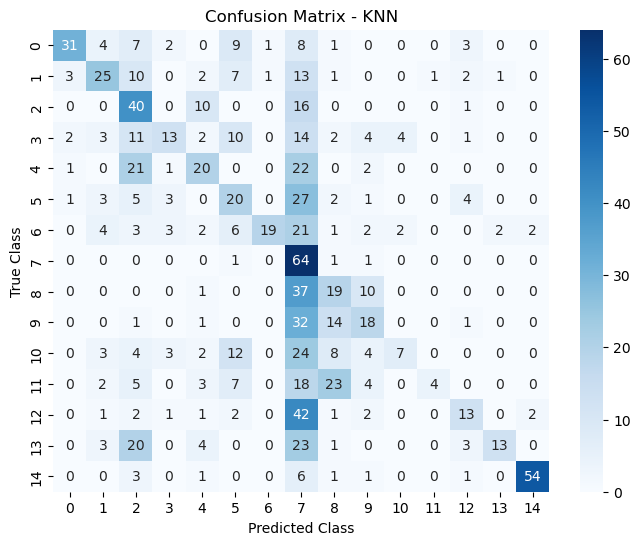


# Decision Tree 

Accuracy: 0.246

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.39      0.41        66
           1       0.18      0.21      0.19        66
           2       0.30      0.27      0.28        67
           3       0.17      0.20      0.18        66
           4       0.21      0.18      0.19        67
           5       0.11      0.09      0.10        66
           6       0.25      0.16      0.20        67
           7       0.69      0.76      0.72        67
           8       0.24      0.27      0.25        67
           9       0.17      0.19      0.18        67
          10       0.25      0.25      0.25        67
          11       0.22      0.17      0.19        66
          12       0.08      0.09      0.08        67
          13       0.16      0.18      0.17        67
          14       0.25      0.27      0.26        67

    accuracy                           0.25      1000
   macro avg       0.

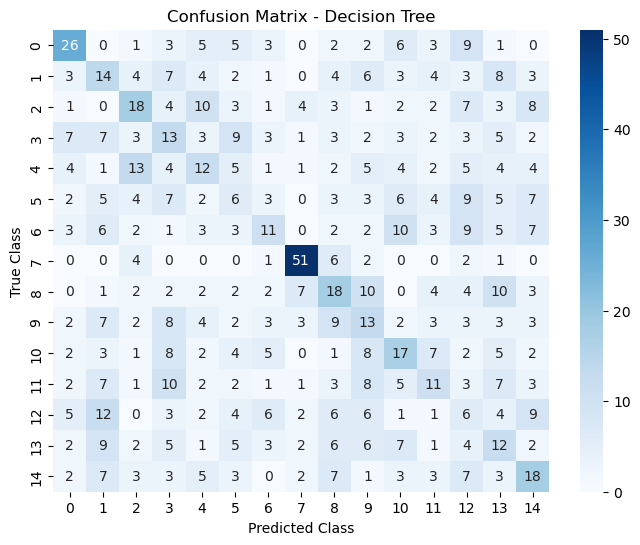


# SGD 

Accuracy: 0.307

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.52      0.50        66
           1       0.25      0.23      0.24        66
           2       0.35      0.24      0.28        67
           3       0.18      0.21      0.20        66
           4       0.27      0.40      0.33        67
           5       0.20      0.30      0.24        66
           6       0.38      0.37      0.38        67
           7       0.50      0.31      0.39        67
           8       0.23      0.24      0.23        67
           9       0.35      0.34      0.35        67
          10       0.35      0.31      0.33        67
          11       0.29      0.26      0.27        66
          12       0.21      0.22      0.22        67
          13       0.25      0.19      0.22        67
          14       0.46      0.45      0.45        67

    accuracy                           0.31      1000
   macro avg       0.32      0.

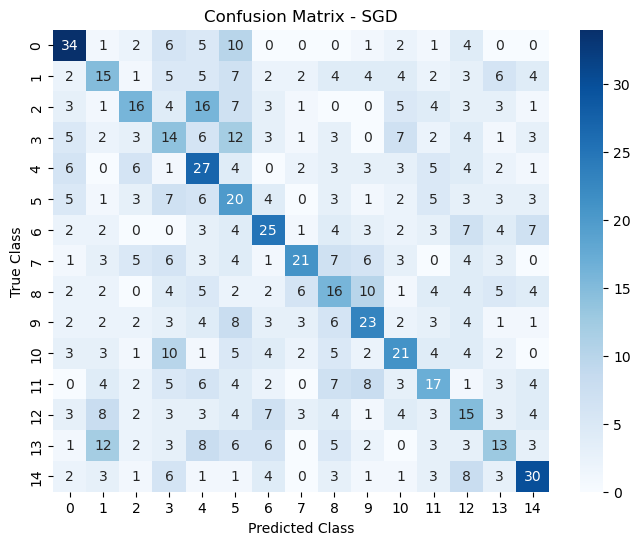

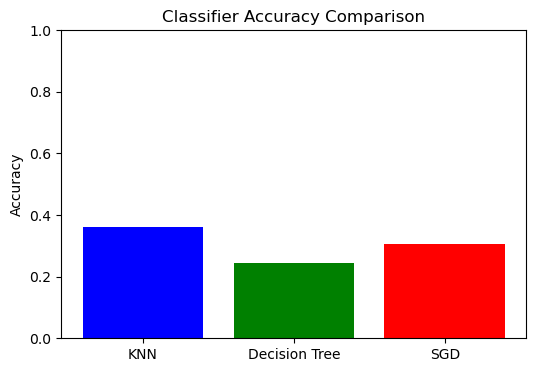

In [42]:
# define evaluate_classifier to show
def evaluate_classifier(name, y_true, y_pred, plot_cm=True):
    print()
    print(f"# {name} ")
    print()
    
    # accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc}\n")
    
    # precision, recall, f1-score
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    if plot_cm:
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()
    
    return acc

# evaluate
acc_knn = evaluate_classifier("KNN", y_test, y_pred_knn)
acc_dt  = evaluate_classifier("Decision Tree", y_test, y_pred_dt)
acc_sgd = evaluate_classifier("SGD", y_test, y_pred_sgd)

# show contrast
plt.figure(figsize=(6,4))
plt.bar(["KNN", "Decision Tree", "SGD"], [acc_knn, acc_dt, acc_sgd], color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")
plt.show()

# Task 2
After completing all the steps below, double the number of training images from 5,000 to
10,000 and repeat the experiment 

find 15000 images
training set: 10000 , testing set: 1000 
training set distributin： Counter({np.int64(12): 667, np.int64(10): 667, np.int64(3): 667, np.int64(14): 667, np.int64(15): 667, np.int64(9): 667, np.int64(5): 667, np.int64(1): 667, np.int64(6): 667, np.int64(2): 667, np.int64(11): 666, np.int64(13): 666, np.int64(8): 666, np.int64(4): 666, np.int64(7): 666})
testing set distributin： Counter({np.int64(1): 67, np.int64(14): 67, np.int64(3): 67, np.int64(15): 67, np.int64(11): 67, np.int64(7): 67, np.int64(13): 67, np.int64(10): 67, np.int64(4): 67, np.int64(8): 67, np.int64(9): 66, np.int64(12): 66, np.int64(2): 66, np.int64(5): 66, np.int64(6): 66})

origin： (10000, 64, 64) (10000,)
train_10000 dataset reshape: (10000, 4096) (10000,)
test dataset reshape: (1000, 4096) (1000,)
classes: 15

 Classifiers initialised

training done

make predictions on the testing data:
KNN_10000 accuracy: 0.461
Decision Tree_10000 accuracy: 0.312
SGD_10000 accuracy: 0.291




# KNN_10000 

Accura

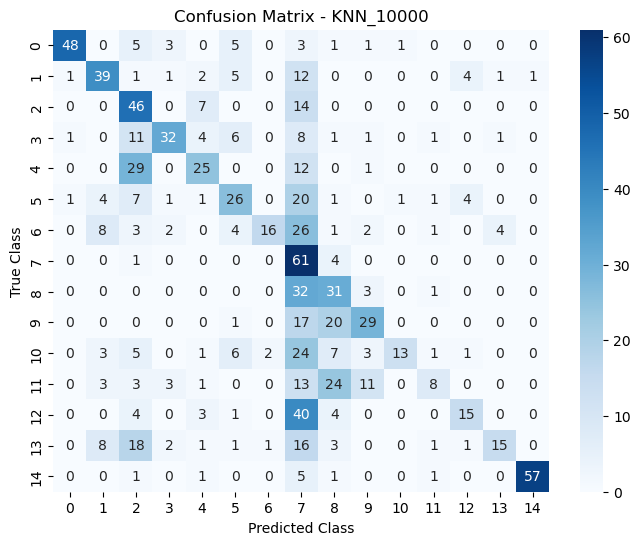


# Decision Tree_10000 

Accuracy: 0.312

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45        67
           1       0.19      0.21      0.20        67
           2       0.37      0.45      0.40        67
           3       0.27      0.26      0.27        66
           4       0.27      0.33      0.29        67
           5       0.15      0.10      0.12        67
           6       0.22      0.16      0.19        67
           7       0.66      0.70      0.68        66
           8       0.34      0.39      0.36        67
           9       0.36      0.39      0.37        67
          10       0.22      0.18      0.20        66
          11       0.19      0.17      0.18        66
          12       0.21      0.24      0.22        67
          13       0.20      0.21      0.20        67
          14       0.45      0.50      0.47        66

    accuracy                           0.31      1000
   macro avg   

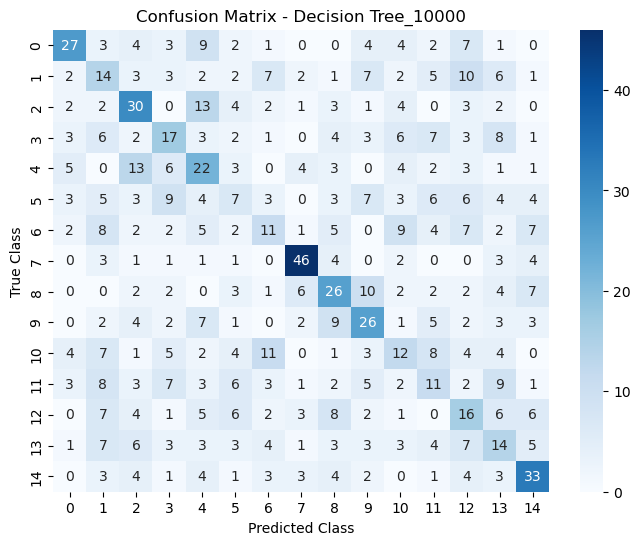


# SGD_10000 

Accuracy: 0.291

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        67
           1       0.27      0.21      0.24        67
           2       0.38      0.39      0.39        67
           3       0.24      0.27      0.26        66
           4       0.36      0.39      0.37        67
           5       0.25      0.07      0.11        67
           6       0.23      0.15      0.18        67
           7       0.54      0.29      0.38        66
           8       0.24      0.19      0.21        67
           9       0.29      0.25      0.27        67
          10       0.28      0.39      0.33        66
          11       0.17      0.48      0.25        66
          12       0.19      0.21      0.20        67
          13       0.39      0.25      0.31        67
          14       0.42      0.36      0.39        66

    accuracy                           0.29      1000
   macro avg       0.31  

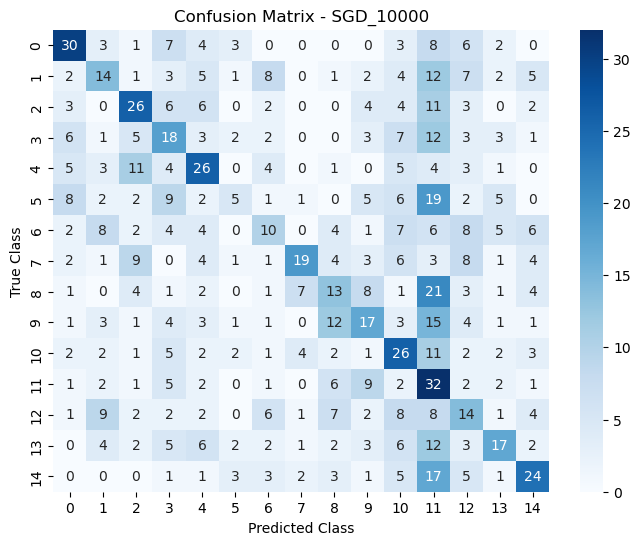

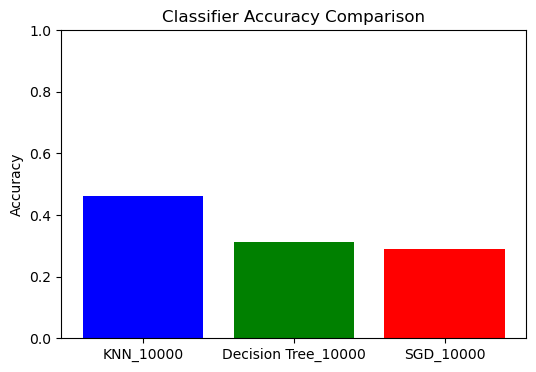

In [45]:
dataDir = './data'
outputDir = './dataset_split'
trainSize = 10000
testSize = 1000
TOTAL_CLASSES = 15
random.seed(42)

# collect label
pattern = re.compile(r"input_(\d+)_(\d+)_(\d+)\.jpg")
image_paths = []
labels = []

for root, _, files in os.walk(dataDir):
    for file in files:
        if file.endswith('.jpg'):
            match = pattern.match(file)
            if match:
                _, _, char_id = map(int, match.groups())
                image_paths.append(os.path.join(root, file))
                labels.append(char_id)

print(f"find {len(image_paths)} images")

# Make sure that random sampling is done in a stratified way
splitter = StratifiedShuffleSplit(
    n_splits=1,
    train_size=trainSize,
    test_size=testSize,
    random_state=42
)

image_paths = np.array(image_paths)
labels = np.array(labels)

for train_idx, test_idx in splitter.split(image_paths, labels):
    train_files = image_paths[train_idx]
    test_files = image_paths[test_idx]
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]

print(f"training set: {len(train_files)} , testing set: {len(test_files)} ")

# create dataset_spilt
def copy_files(files, labels, split_name):
    for path, label in zip(files, labels):
        label_dir = os.path.join(outputDir, split_name, f"class_{label}")
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy2(path, os.path.join(label_dir, os.path.basename(path)))

copy_files(train_files, train_labels, 'train_10000')
copy_files(test_files, test_labels, 'test')

print("training set distributin：", Counter(train_labels))
print("testing set distributin：", Counter(test_labels))
print()

datasetDir = './dataset_split'
imgSize = (64, 64)
colorMode = 'grayscale'

# load dataset
def load_dataset(split):
    data = []
    labels = []
    split_dir = os.path.join(datasetDir, split)
    
    for class_name in sorted(os.listdir(split_dir)):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                img_path = os.path.join(class_dir, filename)
                
                if colorMode == 'grayscale':
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                else:
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, imgSize)
                
                data.append(img)
                labels.append(class_name)
    
    return np.array(data), np.array(labels)

# load train & test
X_train, y_train = load_dataset('train_10000')
X_test, y_test = load_dataset('test')

print("origin：", X_train.shape, y_train.shape)

# reshape
if colorMode == 'grayscale':
    n_features = imgSize[0] * imgSize[1]
    X_train = X_train.reshape(len(X_train), n_features)
    X_test = X_test.reshape(len(X_test), n_features)
else:
    n_features = imgSize[0] * imgSize[1] * 3
    X_train = X_train.reshape(len(X_train), n_features)
    X_test = X_test.reshape(len(X_test), n_features)

# label encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print("train_10000 dataset reshape:", X_train.shape, y_train.shape)
print("test dataset reshape:", X_test.shape, y_test.shape)
print("classes:", len(le.classes_))
print()

# KNN, k=3
knn_clf = KNeighborsClassifier(n_neighbors=3)

# decision tree, default
dt_clf = DecisionTreeClassifier()

# SGD, maximum iterations = 250
sgd_clf = SGDClassifier(max_iter=250)

print(" Classifiers initialised")
print()

# train KNN
knn_clf.fit(X_train, y_train)

# train decision tree
dt_clf.fit(X_train, y_train)

# train SGD
sgd_clf.fit(X_train, y_train)

print("training done")
print()

# KNN
y_pred_knn = knn_clf.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

# decision tree
y_pred_dt = dt_clf.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

# SGD
y_pred_sgd = sgd_clf.predict(X_test)
acc_sgd = accuracy_score(y_test, y_pred_sgd)

print("make predictions on the testing data:")
print(f"KNN_10000 accuracy: {acc_knn}")
print(f"Decision Tree_10000 accuracy: {acc_dt}")
print(f"SGD_10000 accuracy: {acc_sgd}")
print()
print()
print()

# define evaluate_classifier to show
def evaluate_classifier(name, y_true, y_pred, plot_cm=True):
    print()
    print(f"# {name} ")
    print()
    
    # accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc}\n")
    
    # precision, recall, f1-score
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    if plot_cm:
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()
    
    return acc

# evaluate
acc_knn = evaluate_classifier("KNN_10000", y_test, y_pred_knn)
acc_dt  = evaluate_classifier("Decision Tree_10000", y_test, y_pred_dt)
acc_sgd = evaluate_classifier("SGD_10000", y_test, y_pred_sgd)

# show contrast
plt.figure(figsize=(6,4))
plt.bar(["KNN_10000", "Decision Tree_10000", "SGD_10000"], [acc_knn, acc_dt, acc_sgd], color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")
plt.show()